This script loads in some preliminary data for the DATS 6103 final project on GDP Nowcasting.

First we'll load in the packages we need:

In [73]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce


# Ignore warning message (distracting)
import warnings
warnings.filterwarnings("ignore")


In [74]:
%load_ext autoreload
%autoreload 2

import sys, importlib
sys.path.append('.')
import utils
importlib.reload(utils)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils' from 'c:\\Users\\adgo1\\OneDrive\\BACKUP\\Desktop\\DM\\GIT\\GDP-PROJECT\\6103-fall-25-Kennedy-Kuscu-Gomez\\code\\utils.py'>

Now we'll load in the CSVs, stored in the data folder.

In [75]:
# Current new orders for service, from FRED, https://fred.stlouisfed.org/series/NOBNDIF066MSFRBPHI
# monthly, millions of dollars, seasonally adjusted
orders = pd.read_csv("../data/current_new_orders.csv")

# Employment level, from FRED, https://fred.stlouisfed.org/series/CE16OV 
# monthly, thousands of people
employ = pd.read_csv("../data/employment_level.csv")

# UMich Index of consumer sentiment, https://data.sca.isr.umich.edu/data-archive/mine.php 
# monthly, 
consumer = pd.read_csv("../data/index_of_consumer_sentiment_umich.csv", skiprows=1)

# initial unemployment claims, FRED, https://fred.stlouisfed.org/series/ICSA
# number, seasonally adjusted
claims = pd.read_csv("../data/initial_unemployment_claims.csv")

# business outlook survey, from Philly Fed, https://www.philadelphiafed.org/surveys-and-data/mbos-historical-data 
bus_outlook = pd.read_csv("../data/philly_fed_business_outlook_survey.csv")

# auto sales, from FRED, https://fred.stlouisfed.org/series/TOTALSA 
# millions of units, seasonally adjusted
auto = pd.read_csv("../data/total_auto_sales.csv")

# total construction spending, from FRED, https://fred.stlouisfed.org/series/TLMFGCONS
# millions of dollars, seasonally adjusted
construct = pd.read_csv("../data/total_construction_spending_US.csv")

# international trade, US Census, https://www.census.gov/foreign-trade/Press-Release/current_press_release/index.html
# millions of dollars, seasonally adjusted
i_trade = pd.read_excel("../data/monthly_international_trade.xlsx", skiprows = 7)

# wholesale trade, from US Census, https://www.census.gov/wholesale/data/index.html
# milliosn of dollars, seasonally adjusted
w_trade = pd.read_excel("../data/monthly_wholesale_trade.xlsx", skiprows = 7)

#import index from BLS, U.S. Import and Export Price Indexes, https://www.bls.gov/mxp/
import_index = pd.read_csv("../data/import_index.csv")
export_index = pd.read_csv("../data/export_index.csv")

# new houses sold, from U.S.Census, https://www.census.gov/construction/nrs/data/series.html
new_houses_sold = pd.read_csv("../data/new_houses_sold.csv")
#new_houses_sold.head(10)

# manufacturers new orders, from FRED, https://fred.stlouisfed.org/series/AMTMNO
manufacturers = pd.read_csv("../data/manufacturers.csv")

# capacity utilization, from FRED, https://fred.stlouisfed.org/series/TCU
capacity_utilization = pd.read_csv("../data/capacity_utilization.csv")

# advanced retail sales, from FRED, https://fred.stlouisfed.org/series/RSXFS
advanced_retail_sales = pd.read_csv("../data/advanced_retail_sales.csv")

# Standard & Poors and Dow Jones Averages series, from FRED, https://fred.stlouisfed.org/series/SP500
sp500 = pd.read_csv("../data/SP500.csv")

# Personal Income, from FRED, https://fred.stlouisfed.org/series/PI
pi = pd.read_csv("../data/PI.csv")

#ppi
ppi = pd.read_csv("../data/ppi.csv")

#cpi
cpi = pd.read_csv("../data/cpi.csv")

#import
import_index = pd.read_csv("../data/import_index.csv")

# export
export_index = pd.read_csv("../data/export_index.csv")

#fed_surplus_deficit
fed_surplus_deficit = pd.read_csv("../data/fed_surplus_deficit.csv")

In [76]:
# gdp is formatted weirdly so I'll load this and clean it separately

# GDP, from BEA, https://www.bea.gov/data/gdp/gross-domestic-product 
# quarterly, billions of dollars, main dependent variable
gdp = pd.read_csv("../data/gdp_bea.csv", skiprows=3)

years = gdp.columns[2:]  # start after 'Line' and blank col
years = np.floor(pd.to_numeric(years)).values

quarters = gdp.iloc[0, 2:].values

# make a combined year-quarter label
periods = [f"{int(y)}Q{int(q[-1])}" for y, q in zip(years, quarters)]

# Find the gdp row (Line 1)
gdp_row = pd.to_numeric(gdp.iloc[1, 2:].values) 

# make a df with just the date and gdp values
gdp = pd.DataFrame({
    "quarter": periods,
    "gdp": pd.to_numeric(gdp_row, errors="coerce")
})

# create a datetime column
# we have "YYYYQn", want quarterly datetime 
gdp["date"] = pd.PeriodIndex(gdp["quarter"], freq="Q").to_timestamp()

# reorder and keep only the two requested columns
gdp = gdp[["date", "gdp"]]

# make dates end of month (to be consistent with other dfs)
gdp["date"] = gdp["date"] + pd.offsets.QuarterEnd(0)

gdp.head()



,date,gdp
0,1947-03-31,243.2
1,1947-06-30,246.0
2,1947-09-30,249.6
3,1947-12-31,259.7
4,1948-03-31,265.7


First thing I will do is clean this data and merge it into a panel. I'm going to want to a consistent datetime across all variables to merge by, and I want the main variables stored numerically. 

All of my data is monthly so I need to convert to quarterly frequency. 

In [77]:
### orders -----------------------------------------------
orders["date"] = pd.to_datetime(orders["observation_date"])
orders = orders.set_index("date").sort_index()

# sum across months to a quarterly freq
orders_q = orders.resample("Q").sum()  # quarterly sum
# make date not the index
orders_q = orders_q.reset_index()
# select only needed cols
orders_q = orders_q[["date", "NOBNDIF066MSFRBPHI"]]

orders_q.rename(columns={'NOBNDIF066MSFRBPHI': 'orders'}, inplace=True)

### employment -----------------------------------------------
employ["date"] = pd.to_datetime(employ["observation_date"])
employ = employ.set_index("date").sort_index()

# sum across months to a quarterly freq
employ_q = employ.resample("Q").sum()  # quarterly sum
employ_q = employ_q.reset_index()

employ_q = employ_q[["date", "CE16OV"]]

employ_q.rename(columns={'CE16OV': 'employment'}, inplace=True)

### consumer -----------------------------------------------
consumer["date"] = pd.to_datetime(consumer[["Year", "Month"]].assign(day=1))

consumer["date"] = pd.to_datetime(consumer["date"])
consumer = consumer.set_index("date").sort_index()

# average across months to a quarterly freq
consumer_q = consumer.resample("Q").mean()  # quarterly average
consumer_q = consumer_q.reset_index()

consumer_q = consumer_q[["date", "Index"]]

consumer_q.rename(columns={'Index': 'consumer_sentiment'}, inplace=True)


### claims -----------------------------------------------
claims["date"] = pd.to_datetime(claims["observation_date"])
claims = claims.set_index("date").sort_index()

# sum across months to a quarterly freq
claims_q = claims.resample("Q").sum()  # quarterly sum
claims_q = claims_q.reset_index()

claims_q = claims_q[["date", "ICSA"]]

claims_q.rename(columns={'ICSA': 'unemploy_claims'}, inplace=True)


### bus_outlook -----------------------------------------------
bus_outlook["date"] = pd.to_datetime(bus_outlook["DATE"], format="%b-%y")
# fix some future years
bus_outlook.loc[bus_outlook["date"].dt.year > 2025, "date"] -= pd.DateOffset(years=100)

bus_outlook = bus_outlook.set_index("date").sort_index()
bus_outlook = bus_outlook[["GAC"]]

# average across months to a quarterly freq
bus_outlook_q = bus_outlook.resample("Q").mean()  # quarterly average
bus_outlook_q = bus_outlook_q.reset_index()

bus_outlook_q = bus_outlook_q[["date", "GAC"]]

bus_outlook_q.rename(columns={'GAC': 'bus_outlook'}, inplace=True)

### auto -----------------------------------------------
auto["date"] = pd.to_datetime(auto["observation_date"])
auto = auto.set_index("date").sort_index()

# sum across months to a quarterly freq
auto_q = auto.resample("Q").sum()  # quarterly sum
auto_q = auto_q.reset_index()

auto_q = auto_q[["date", "TOTALSA"]]

auto_q.rename(columns={'TOTALSA': 'auto_sales'}, inplace=True)


### construct -----------------------------------------------
construct["date"] = pd.to_datetime(construct["observation_date"])
construct = construct.set_index("date").sort_index()

# sum across months to a quarterly freq
construct_q = construct.resample("Q").sum()  # quarterly sum
construct_q = construct_q.reset_index()

construct_q = construct_q[["date", "TLMFGCONS"]]

construct_q.rename(columns={'TLMFGCONS': 'construction'}, inplace=True)


### i_trade -----------------------------------------------
i_trade["date"] = pd.to_datetime(i_trade["Period"], format="%b-%Y")
i_trade = i_trade.set_index("date").sort_index()

# sum across months to a quarterly freq
i_trade_q = i_trade.resample("Q").sum()
i_trade_q = i_trade_q.reset_index()

i_trade_q = i_trade_q[["date", "Value"]]

i_trade_q.rename(columns={'Value': 'itrade'}, inplace=True)

### w_trade -----------------------------------------------
w_trade["date"] = pd.to_datetime(w_trade["Period"], format="%b-%Y")
w_trade = w_trade.set_index("date").sort_index()

# sum across months to a quarterly freq
w_trade_q = w_trade.resample("Q").sum()
w_trade_q = w_trade_q.reset_index()

w_trade_q = w_trade_q[["date", "Value"]]

w_trade_q.rename(columns={'Value': 'wtrade'}, inplace=True)


### new houses sold  -------------------------------------------------
new_houses_sold["date"] = pd.to_datetime(new_houses_sold["Date"], format="%b %Y")
new_houses_sold = new_houses_sold.set_index("date").sort_index()
houses_q = new_houses_sold.resample("QE").sum().reset_index()
houses_q = houses_q[["date", "Thousands of homes sold per month"]]
houses_q = houses_q.rename(columns={"Thousands of homes sold per month": "new_houses"})
#houses_q.head(10)

### manufacturers new orders -----------------------------------------
manufacturers["date"] = pd.to_datetime(manufacturers["observation_date"])
manufacturers = manufacturers.set_index("date").sort_index()
manufacturers_q = manufacturers["AMTMNO"].resample("QE").sum()
manufacturers_q = manufacturers_q.reset_index()
manufacturers_q = manufacturers_q.rename(columns={"AMTMNO": "new_orders"})
manufacturers_q = manufacturers_q[["date", "new_orders"]]
#manufacturers_q.head(10)

### capacity utilization -----------------------------------------
capacity_utilization["date"] = pd.to_datetime(capacity_utilization["observation_date"])
capacity_utilization = capacity_utilization.set_index("date").sort_index()
capacity_utilization_q = capacity_utilization["TCU"].resample("QE").mean()
capacity_utilization_q = capacity_utilization_q.reset_index()
capacity_utilization_q = capacity_utilization_q.rename(columns={"TCU": "cap_util"})
capacity_utilization_q = capacity_utilization_q[["date", "cap_util"]]

### advanced retail sales -----------------------------------------
advanced_retail_sales["date"] = pd.to_datetime(advanced_retail_sales["observation_date"])
advanced_retail_sales = advanced_retail_sales.set_index("date").sort_index()
advanced_retail_sales_q = advanced_retail_sales["RSXFS"].resample("QE").sum()
advanced_retail_sales_q = advanced_retail_sales_q.reset_index()
advanced_retail_sales_q = advanced_retail_sales_q.rename(columns={"RSXFS": "retail_sales"})
advanced_retail_sales_q = advanced_retail_sales_q[["date", "retail_sales"]]

### SP500 ---------------------------------------------------------------------------
sp500["date"] = pd.to_datetime(sp500["observation_date"])
sp500 = sp500.set_index("date").sort_index()
sp500_q = sp500["SP500"].resample("QE").mean()
sp500_q = sp500_q.reset_index()
sp500_q = sp500_q.rename(columns={"SP500": "sp500"})
sp500_q = sp500_q[["date", "sp500"]]

### Personal Income ---------------------------------------------------------------------------
pi["date"] = pd.to_datetime(pi["observation_date"])
pi = pi.set_index("date").sort_index()
pi_q = pi["PI"].resample("QE").mean()
pi_q = pi_q.reset_index()
pi_q = pi_q.rename(columns={"PI": "pers_income"})
pi_q = pi_q[["date", "pers_income"]]


#ppi
ppi["date"] = pd.to_datetime(ppi["DATE"])
ppi = ppi.set_index("date").sort_index()
ppi_q = ppi["PPIACO"].resample("Q").mean().reset_index()
ppi_q = ppi_q[["date", "PPIACO"]]
ppi_q.rename(columns={'PPIACO': 'ppi'}, inplace=True)

#cpi
cpi["date"] = pd.to_datetime(cpi["DATE"])
cpi = cpi.set_index("date").sort_index()
cpi_q = cpi["CPIAUCSL"].resample("Q").mean().reset_index()
cpi_q = cpi_q[["date", "CPIAUCSL"]]
cpi_q.rename(columns={'CPIAUCSL': 'cpi'}, inplace=True)
#import and export index quarterly conversion
from utils import read_wide_monthly_to_quarterly
from utils import read_monthly_flow_to_quarterly_sum
#import index
import_index_q = read_wide_monthly_to_quarterly(
    "../data/import_index.csv",
    value_name="import_index"
)
#export index
export_index_q = read_wide_monthly_to_quarterly(
    "../data/export_index.csv",
    value_name="export_index")
#fed surplus deficit
mts_q = read_monthly_flow_to_quarterly_sum(
    "../data/fed_surplus_deficit.csv",
    value_name="federal_deficit"
)

#durable goods orders
dgorder_q = read_monthly_flow_to_quarterly_sum(
    "../data/DGORDER.csv",
    value_name="durable_orders"
)
from utils import (
    read_wide_monthly_to_quarterly,
    read_monthly_flow_to_quarterly_sum,
    read_monthly_level_to_quarterly_mean
)

#industrial production
indprod_q = read_monthly_level_to_quarterly_mean(
    "../data/Industrial_Prod.csv",
    value_name="indprod"
)
indprod_q.head()

from utils import read_census_period_value_excel_to_quarterly_sum
#new residential construction
nrc_q = read_census_period_value_excel_to_quarterly_sum(
    "../data/NRC.xlsx",
    sheet_name="CIDR",
    skiprows=7,
    value_name="nrc_units"
)
nrc_q.head()
#neww house sales
nhs_q = read_census_period_value_excel_to_quarterly_sum(
    "../data/SeriesReport-202511200226-V.xlsx",
    sheet_name="CIDR",
    skiprows=7,
    value_name="new_home_sales"
)

#nhs_q.head()

Now to merge into one final dataset.

In [78]:
vars = [gdp, orders_q, employ_q, consumer_q, claims_q, bus_outlook_q, auto_q, construct_q, i_trade_q,
         w_trade_q, houses_q, manufacturers_q, capacity_utilization_q, advanced_retail_sales_q,
         sp500_q, pi_q, ppi_q, cpi_q,import_index_q, export_index_q,mts_q,dgorder_q,indprod_q,nrc_q,nhs_q]  # list all my quarterly dfs

data = reduce(lambda left, right: pd.merge(left, right, on="date", how="outer"), vars)

data = data.sort_values("date").reset_index(drop=True)

# save data
data.to_csv("data_wpk.csv", index = False)

data.tail()

,date,gdp,orders,employment,consumer_sentiment,unemploy_claims,bus_outlook,auto_sales,construction,itrade,...,pers_income,ppi,cpi,import_index,export_index,federal_deficit,durable_orders,indprod,nrc_units,new_home_sales
447,2024-12-31,29825.2,5.9,484300.0,72.100000,2931000.0,-3.100000,50.866,703643.0,-250950.0,...,25322.433333,253.238333,316.538667,141.266667,149.033333,-710945.026573,872165.0,102.402933,4416.0,2014.0
448,2025-03-31,30042.1,-19.2,490710.0,64.466667,2874000.0,24.966667,50.721,690353.0,-385498.0,...,25717.733333,258.461000,319.492000,141.833333,152.233333,-596187.722872,901395.0,103.430600,4395.0,1964.0
449,2025-06-30,30485.7,-43.3,490608.0,55.033333,3039000.0,-11.466667,49.699,678440.0,-190393.0,...,26067.100000,259.241333,320.800333,141.700000,152.600000,-30593.789997,951059.0,103.830300,4209.0,2009.0
450,2025-09-30,NaN,31.7,326500.0,58.333333,2749000.0,12.933333,33.698,223053.0,-78311.0,...,26232.050000,262.502500,323.288000,141.400000,153.200000,-437984.921784,614792.0,103.869850,2692.0,1464.0
451,2025-12-31,NaN,-17.4,NaN,NaN,NaN,-12.800000,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I was going to deal with missing values, but upon closer inspection it looks like we're basically good! 

Let's do some quick histograms instead.

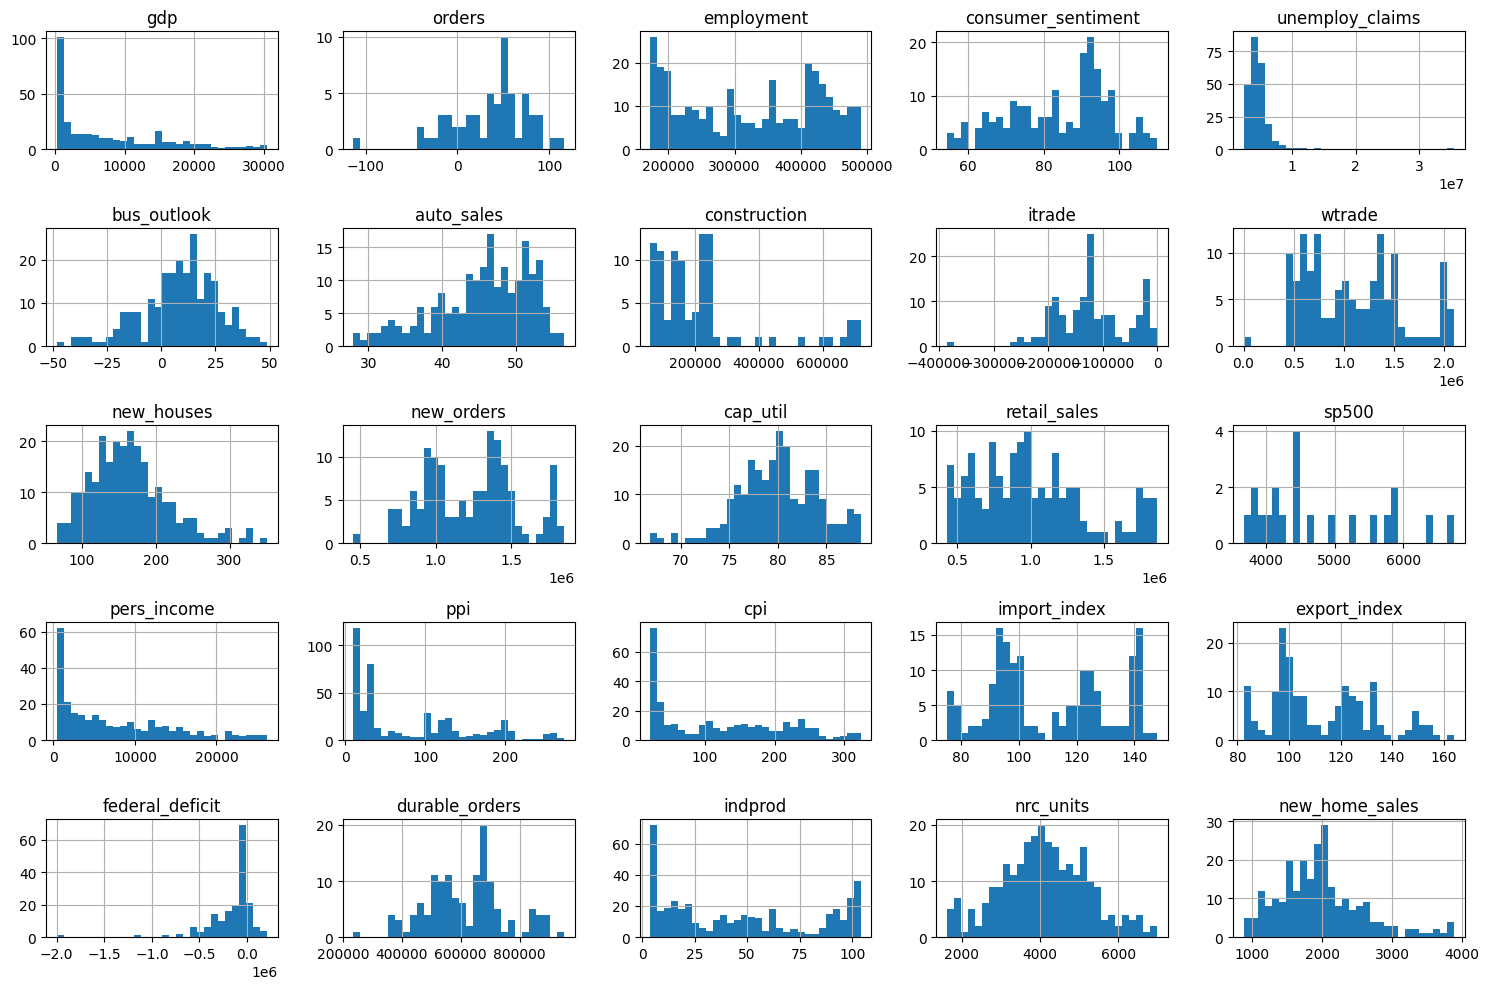

In [79]:
numeric_cols = data.select_dtypes(include="number").columns.drop("date", errors="ignore")

data[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Now let's get an idea of the correlations between variables.

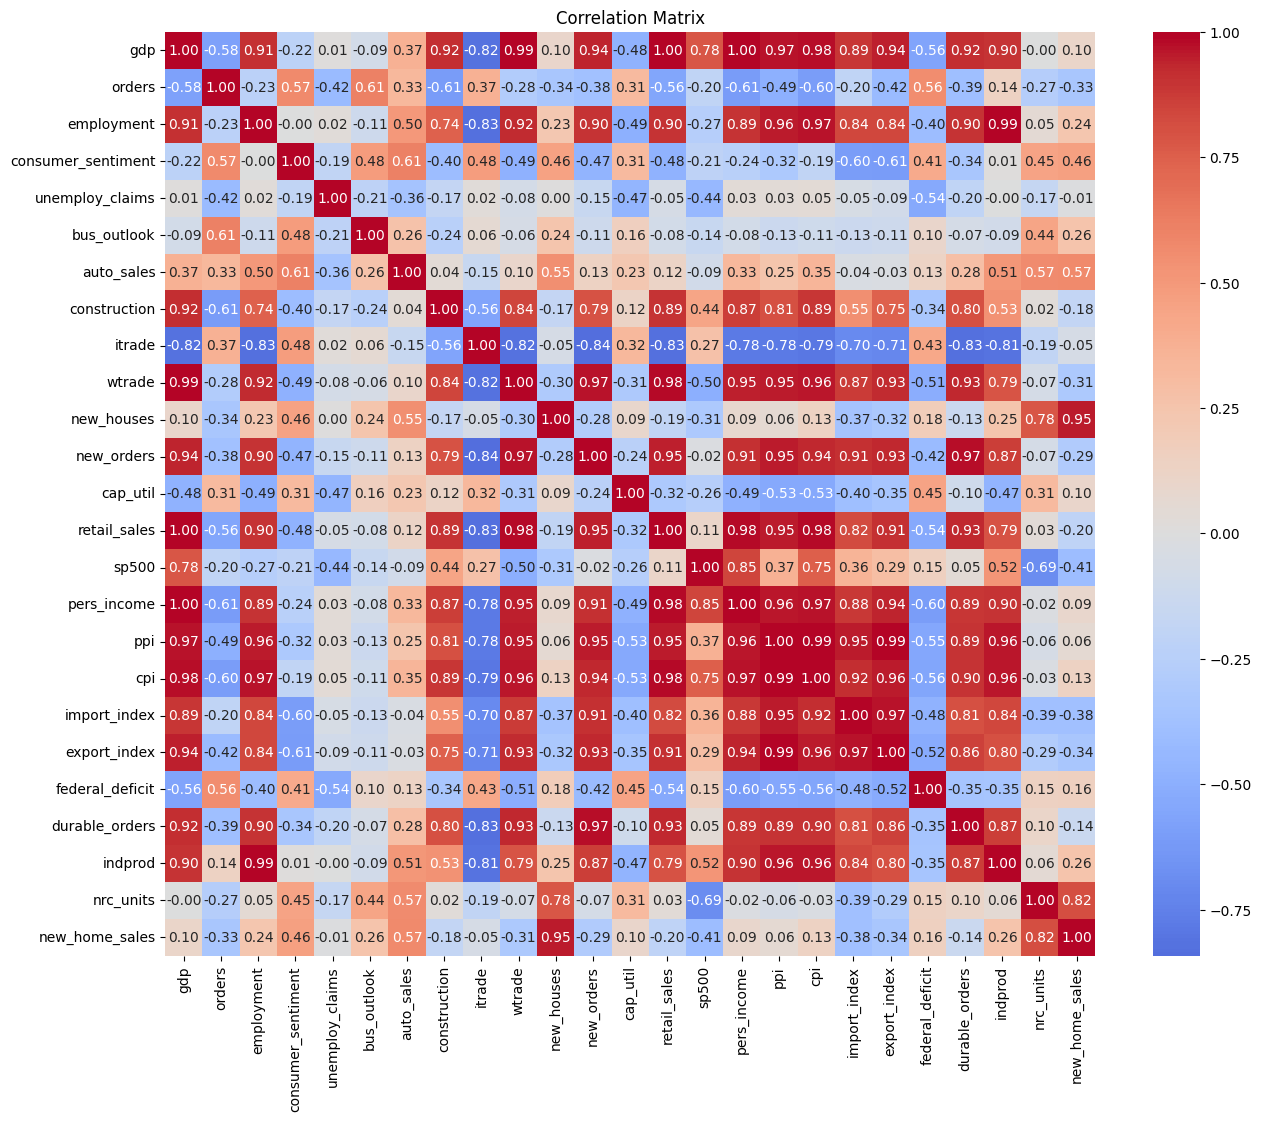

In [80]:
corr = data.select_dtypes(include="number").corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

Massive multicollinearity that can harm the model. Let's try fewer predictors and based on the general GDP Forecasting well-known formula: GDP = Consumption + Investment + Government Spending + (Exports − Imports)

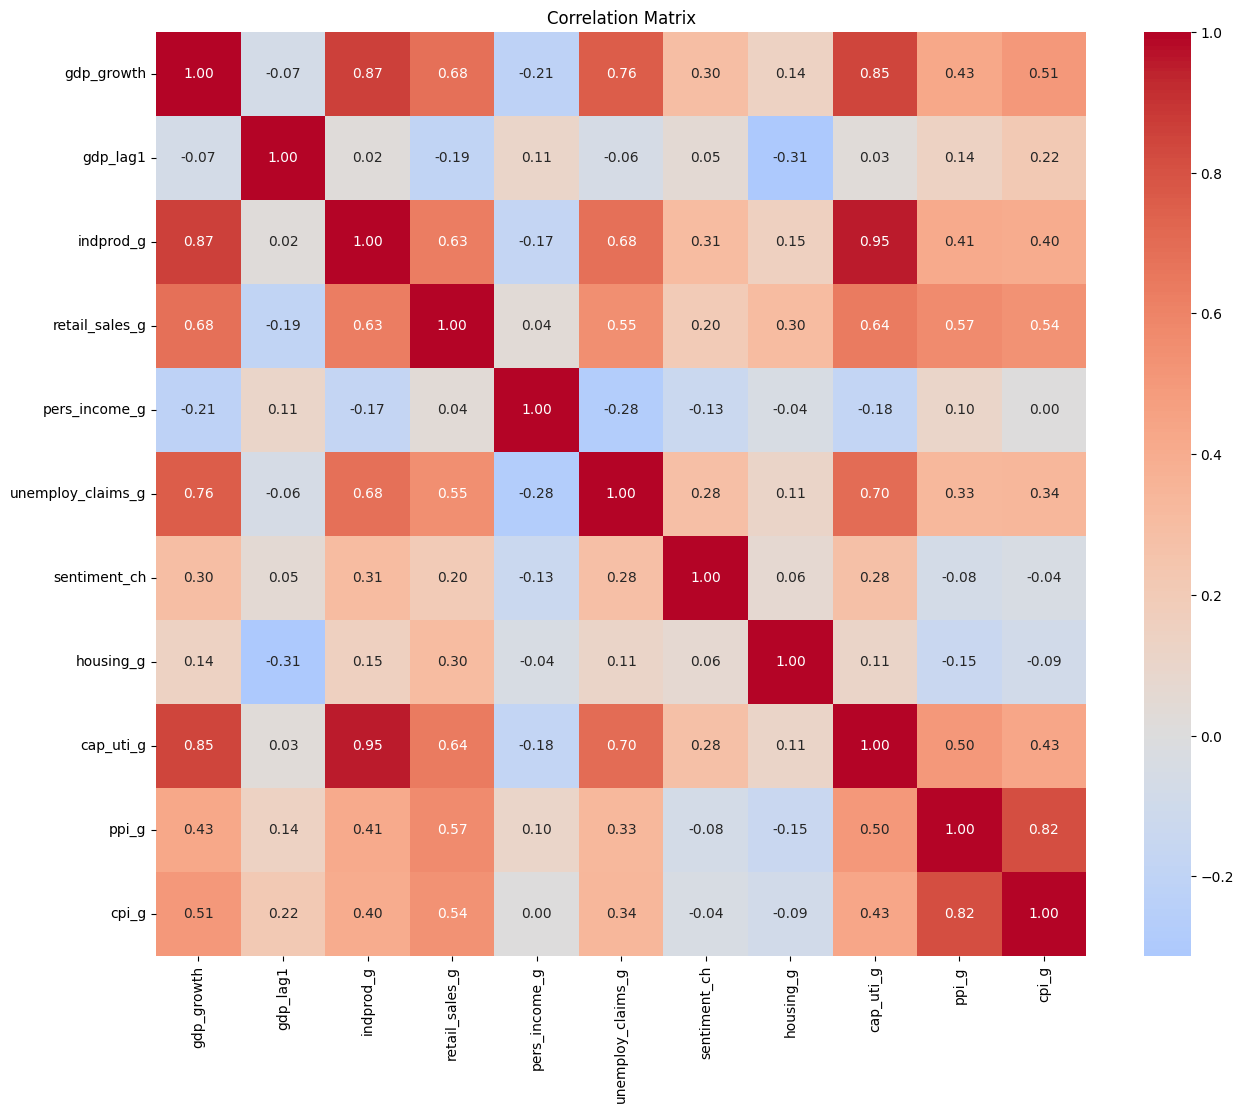

In [81]:
# We use log + diff because it turns GDP and the indicators into growth rates.
# Log puts everything on a percent-like scale, and diff measures the change.
# Together, log-diff tells us how fast each variable is growing each quarter.


# indprod_g - industrial production (real activity)
# retail_sales_g - consumption
# pers_income_g - income behind consumption
# unemploy_claims_g - labor market stress (inverted)
# sentiment_ch - expectations
# housing_g - residential investment


data["gdp_growth"]        = np.log(data["gdp"]).diff()
data["indprod_g"]         = np.log(data["indprod"]).diff()
data["retail_sales_g"]    = np.log(data["retail_sales"]).diff()
data["pers_income_g"]     = np.log(data["pers_income"]).diff()
data["unemploy_claims_g"] = np.log(data["unemploy_claims"]).diff() * -1  # higher claims = worse economy. 
data["sentiment_ch"]      = data["consumer_sentiment"].diff()
data["housing_g"]         = np.log(data["new_home_sales"]).diff()
data["cap_uti_g"]         = data["cap_util"].diff()              # or log-diff if always > 0
data["ppi_g"]             = np.log(data["ppi"]).diff()
data["cpi_g"]             = np.log(data["cpi"]).diff()

data["gdp_lag1"]          = data["gdp_growth"].shift(1)


model_df = data[[
    "gdp_growth",
    "gdp_lag1",
    "indprod_g",
    "retail_sales_g",
    "pers_income_g",
    "unemploy_claims_g",
    "sentiment_ch",
    "housing_g",
    "cap_uti_g",
    "ppi_g",
    "cpi_g"
]].dropna()

corr = model_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

# save data
model_df = data[[
    "date",
    "gdp_growth",
    "gdp_lag1",
    "indprod_g",
    "retail_sales_g",
    "pers_income_g",
    "unemploy_claims_g",
    "sentiment_ch",
    "housing_g",
    "cap_uti_g",
    "ppi_g",
    "cpi_g"
]].dropna()
model_df.to_csv("data_wpk_few_predictors.csv", index = False)